# Dynamic Time Warping for Non-Anthropomorphic Hand Data

In [1]:
pip install fastdtw

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Set up:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits import mplot3d

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
%matplotlib notebook

In [2]:
def dtw_data_import(set_num, run):

#     Y-position of hand and end-effector tend to be most consistently aligned. Use those to discover the time warp mapping

    filename = "C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\j2s6s300_end_effectorMotion_"+str(run)+".csv"
    # Import data from csvs
    end_eff_raw = pd.read_csv(filename)
    end_eff_data = end_eff_raw.to_numpy()
    
    filename = "C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\RightHandAnchorMotion_"+str(run)+".csv"
    hand_raw = pd.read_csv(filename)
    hand_data = hand_raw.to_numpy()
    
    filename = "C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\j2s6s300_JointMotion_"+str(run)+".csv"
    jointangles = pd.read_csv(filename)
    joint_data = jointangles.to_numpy()

    return end_eff_data, hand_data, joint_data



In [64]:
def norm_data(end_eff_data, hand_data, axis_num):
    
    
    endpt = -100
    
    x = (end_eff_data[:endpt,0],end_eff_data[:endpt,axis_num])
    y = (hand_data[:endpt,0],hand_data[:endpt,axis_num])


    # Normalize x and y to prevent scaling issues from creating DTW misalignment

    scale_x = 1/(np.max(x[1])-np.min(x[1]))
    scale_y = 1/(np.max(y[1])-np.min(y[1]))

#     center_x = np.mean(x[1])
#     center_y = np.mean(y[1])
    center_x = np.max(x[1])
    center_y = np.max(y[1])

    x_norm = (x[0],(x[1] - center_x)*scale_x)
    y_norm = (y[0],(y[1] - center_y)*scale_y)

    # TO-DO: trim ends for cleaner DTW
    # (Not done yet)

    dtw_distance, warp_path = fastdtw(x_norm[1], y_norm[1], dist=euclidean) 
    print("axis choice = "+str(axis_num))
    print(dtw_distance)
    
    return warp_path, x_norm[1], y_norm[1], dtw_distance

def find_norm(set_num, run, end_eff_data, hand_data):
#     if (run==10):

#         labels = ["X","Y","Z"]

    axis_choice = 1
    temp_distance = 10000 # initialize to ridiculously high value

    for i in range(1,4):
        warp_path, x_norm, y_norm, distance = norm_data(end_eff_data, hand_data, i)        
#         plot_norm(set_num, run, warp_path, x_norm, y_norm, i, show_subplots=True)
        if (distance<temp_distance):
            temp_distance=distance
            axis_choice=i

#         final_axis_choice = int(input("Which axis shows the best synchrony? 1=X, 2=Y, 3=Z"))

    plt.close('all')

#     else:
#         final_axis_choice = axis_choice
        
    warp_path, x_norm, y_norm, distance = norm_data(end_eff_data, hand_data, axis_choice)
    plot_norm(set_num, run, warp_path, x_norm, y_norm, axis_choice, show_subplots=False)
    
    plt.close('all')
    return warp_path, axis_choice
    

In [4]:
def plot_norm(set_num, run, warp_path, x_norm, y_norm, axis_num, show_subplots):
    # Show normalized plots
    
    if show_subplots:
        subplots = [131,132,133]
        fig = plt.figure(figsize=[17.0, 5.0])
        ax = fig.add_subplot(subplots[axis_num-1])
    else: 
        fig, ax = plt.subplots(figsize=(12, 6))
    
    
    # Remove the border and axes ticks
    fig.patch.set_visible(True)
    ax.axis('on')

#     max_distance = 0;
#     i = 0;

    for [map_x, map_y] in warp_path:

        ax.plot([map_x, map_y], [x_norm[map_x], y_norm[map_y]], '--k', linewidth=0.2)
#         temp_arr2 = np.array((x_norm[map_x], y_norm[map_y]))
#         max_distance = np.maximum(max_distance, np.linalg.norm(temp_arr2))
#         i=i+1

    ax.plot(x_norm, '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    ax.plot(y_norm, '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

    labels = ["X","Y","Z"]
    ax.set_title("Normalized DTW Distance for "+labels[axis_num-1]+" Axis", fontsize=10, fontweight="bold")
    if (show_subplots):
        plt.show()
        plt.savefig('NormDTW_allaxes_'+str(run)+'.png')
    else:
        plt.savefig('NormDTW_'+labels[axis_num-1]+'_'+str(run)+'.png')      

    return

In [5]:
# Take the warp_path generated from normalized hand/URDF data and use that to align all other hand data
def full_align(warp_path, end_eff_data, hand_data):
    # Time marks: 
    time_URDF = end_eff_data[...,0]
    time_hand = hand_data[...,0]

    # remember that x = end_eff_pos
    #               y = hand_pos

    # Z-data (forward/back) is offset by the distance between the viewer and the robot. Let's remove that distance for comparison purposes

    wp_size = len(warp_path)
    time_URDF_aligned = np.zeros(wp_size)
    time_hand_aligned = np.zeros(wp_size)
    end_eff_pos_aligned = np.zeros((wp_size,3))
    end_eff_rot_aligned = np.zeros((wp_size,3))
    hand_pos_aligned = np.zeros((wp_size,3))
    hand_rot_aligned = np.zeros((wp_size,3))

    for i, [map_x, map_y] in enumerate(warp_path, start=0):   
        time_URDF_aligned[i] = time_URDF[map_x]
        time_hand_aligned[i] = time_hand[map_y]
        end_eff_pos_aligned[i][0:3] = end_eff_data[map_x][1:4]
        end_eff_rot_aligned[i][0:3] = end_eff_data[map_x][4:]
        hand_pos_aligned[i][0:3]    = hand_data[map_y][1:4]
        hand_rot_aligned[i][0:3]    = hand_data[map_y][4:]
    
    return time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned

In [6]:
def full_joint_align(time_URDF_aligned, joint_data):
    # Time marks: 
    time_ja   = joint_data[...,0]

    wp_size = len(time_URDF_aligned)
    time_ja_aligned   = np.zeros(wp_size)
    joint_data_aligned = np.zeros((wp_size,6))

    j=0
    for (i,time_step) in enumerate(time_URDF_aligned):
        moment=time_URDF_aligned[i]
#         print(str(time_step) + " " + str(moment))
        time_match = np.nonzero(time_ja[j:-1]>=moment)
#         print(str(i)+" "+str(time_match[0][0]))
        if (len(time_match[0]) <= 1):
            j=len(time_ja)-1
#             print("end of line: "+str(j))
        else: 
            j = j+time_match[0][0]
#             print("middle of line: "+str(j))
#         print("default: "+str(j))
        time_ja_aligned[i] = time_ja[j]
#         print(time_ja[j])
        joint_data_aligned[i][0:5] = joint_data[j][1:6]
#         print(joint_data[j][1:6])
    
    return time_ja_aligned, joint_data_aligned

In [7]:
def plot_pos(set_num, run, warp_path, end_eff_pos_aligned, hand_pos_aligned):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Show the border and axes ticks,
    fig.patch.set_visible(True)
    ax.axis('on')

    ax = plt.axes(projection='3d')

    # ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[0], '-ro', label='End-effector position', \
    #     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    # ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[1], '-ro', label='End-effector position', \
    #     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    # ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[2], '-ro', label='End-effector position', \
    #     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')

    # Unity uses a left-handed coordinate system, so plot your position data in the orientation in which it was gathered:
    #  X moving left to right, Z moving front to back, and Y pointing up and down
    ax.scatter(end_eff_pos_aligned[:].T[0], -end_eff_pos_aligned[:].T[2], end_eff_pos_aligned[:].T[1], \
                c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector position')
    ax.scatter(hand_pos_aligned[:].T[0]   , -hand_pos_aligned[:].T[2]   , hand_pos_aligned[:].T[1]   , \
               c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

    # ax.plot3D(end_eff_pos_aligned[:].T[0], end_eff_pos_aligned[:].T[1], end_eff_pos_aligned[:].T[2], \
    #     '-ro', label='End-effector position', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    # ax.plot3D(hand_pos_aligned[:].T[0]   , hand_pos_aligned[:].T[1]   , hand_pos_aligned[:].T[2]   , \
    #     '-bo', label='Hand position', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

    for [map_x, map_y] in warp_path: 
        ax.plot3D([end_eff_pos_aligned[map_x].T[0], hand_pos_aligned[map_y].T[0]], \
                  [-end_eff_pos_aligned[map_x].T[2], -hand_pos_aligned[map_y].T[2]],\
                  [end_eff_pos_aligned[map_x].T[1], hand_pos_aligned[map_y].T[1]], \
                  '--k', linewidth=0.2)

    ax.set_xlabel('Horizontal position')
    ax.set_ylabel('Forward/Back position')
    ax.set_zlabel('Vertical position')

    ax.set_title("DTW Alignment of Hand and URDF End-Effector Position", fontsize=10, fontweight="bold")
    plt.savefig('DTW_Pos'+str(run)+'.png')
    plt.close('all')
    
    return

In [43]:
def clean_rot_data(set_num, run, hand_rot_aligned):
    # Fix angle inversion issues for hand data

    fig, ax = plt.subplots(figsize=(10, 7))

    for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=1):
        # Singularities should occur in all axes simultaneously
        if i==len(hand_rot_aligned):
            continue
        elif np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-1].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-1].T[0]):
#             print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]
        elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-1].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-1].T[1]):
#             print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]
        elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-1].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-1].T[2]):
#             print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]

    # for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=2):
    #     # Singularities should occur in all axes simultaneously
    #     if np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-2].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-2].T[0]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]
    #     elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-2].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-2].T[1]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]
    #     elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-2].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-2].T[2]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]

    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[0], '-ko', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[1], '-bo', label='x', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[2], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='red', markeredgecolor='red')

    plt.savefig('DTW_Rot_corrected_'+str(run)+'.png')
    plt.close('all')
    
    return hand_rot_aligned

In [9]:
def plot_rot(set_num, run, warp_path, end_eff_rot_aligned, hand_rot_aligned):
    # Plot DTW-aligned hand/end-effector orientation

    fig, ax = plt.subplots(figsize=(15, 10))

    # Show the border and axes ticks
    fig.patch.set_visible(True)
    ax.axis('on')

    ax = plt.axes(projection='3d')

    ax.scatter(end_eff_rot_aligned[:].T[0], -end_eff_rot_aligned[:].T[2], end_eff_rot_aligned[:].T[1], \
              c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
    ax.scatter(hand_rot_aligned[:].T[0]   , -hand_rot_aligned[:].T[2]   , hand_rot_aligned[:].T[1]   , \
              c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')

    for [map_x, map_y] in warp_path: 
        ax.plot3D([end_eff_rot_aligned[map_x].T[0], hand_rot_aligned[map_y].T[0]], \
                  [-end_eff_rot_aligned[map_x].T[2], -hand_rot_aligned[map_y].T[2]],\
                  [end_eff_rot_aligned[map_x].T[1], hand_rot_aligned[map_y].T[1]], \
                  '--k', linewidth=0.2)

    ax.set_title("DTW Alignment of Hand and URDF End-Effector Orientation", fontsize=10, fontweight="bold")
    plt.savefig('DTW_Rot'+str(run)+'.png')
    plt.close('all')
    
    return

axis choice = 1
21.802406255548085


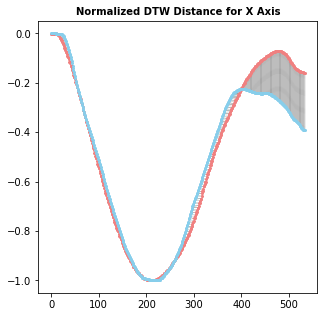

axis choice = 2
4.852258241457754


<Figure size 432x288 with 0 Axes>

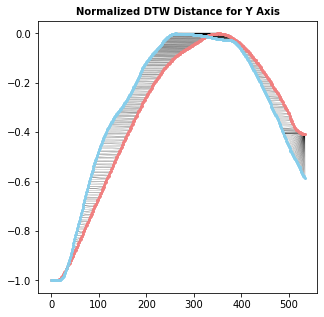

axis choice = 3
12.30277194060904


<Figure size 432x288 with 0 Axes>

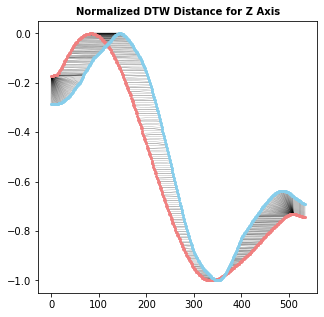

axis choice = 2
4.852258241457754
axis choice = 1
14.742338733566543


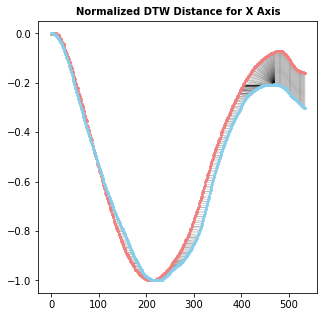

axis choice = 2
3.109202812151686


<Figure size 432x288 with 0 Axes>

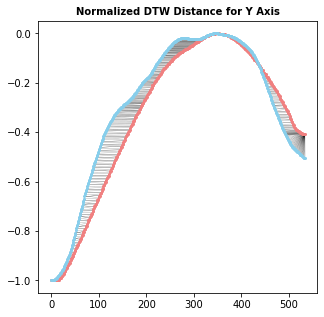

axis choice = 3
10.246307182925616


<Figure size 432x288 with 0 Axes>

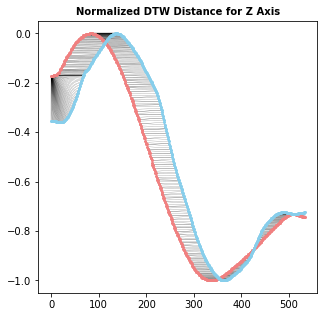

axis choice = 2
3.109202812151686
axis choice = 1
16.564136342109485


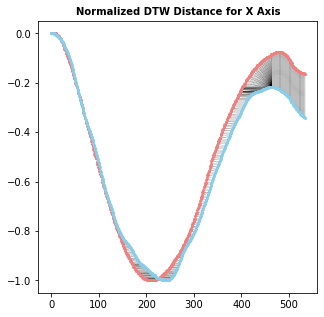

axis choice = 2
4.534599480961479


<Figure size 432x288 with 0 Axes>

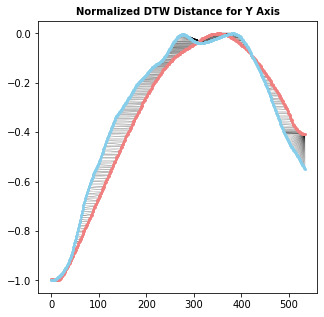

axis choice = 3
13.772401059494676


<Figure size 432x288 with 0 Axes>

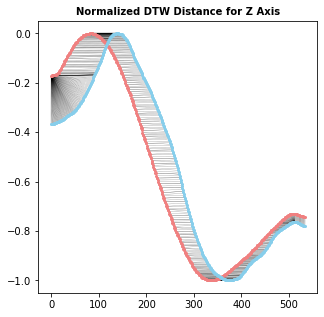

axis choice = 2
4.534599480961479
axis choice = 1
5.99117823450341


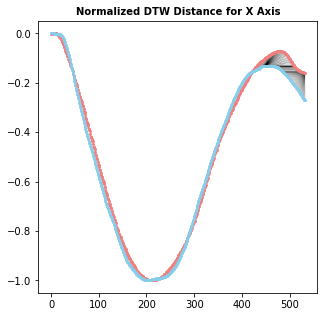

axis choice = 2
3.436219107231097


<Figure size 432x288 with 0 Axes>

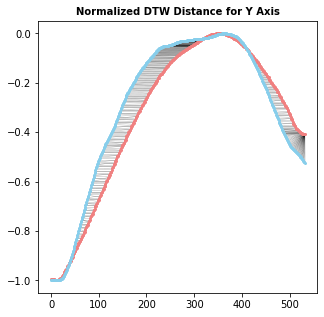

axis choice = 3
22.136669849934627


<Figure size 432x288 with 0 Axes>

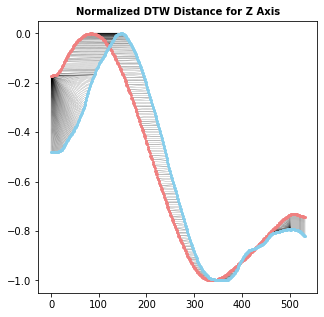

axis choice = 2
3.436219107231097
axis choice = 1
13.39635250151214


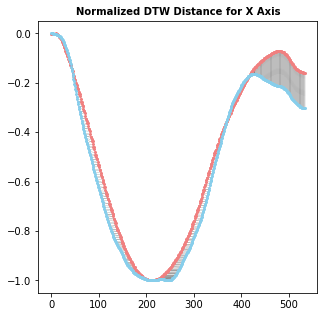

axis choice = 2
5.150399762663602


<Figure size 432x288 with 0 Axes>

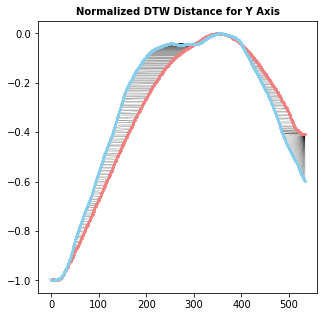

axis choice = 3
16.649144897696978


<Figure size 432x288 with 0 Axes>

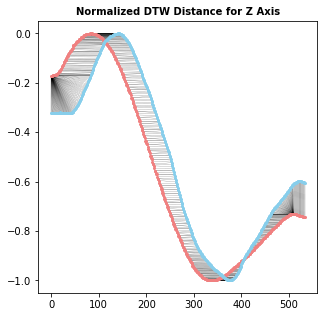

axis choice = 2
5.150399762663602
axis choice = 1
22.365845728613404


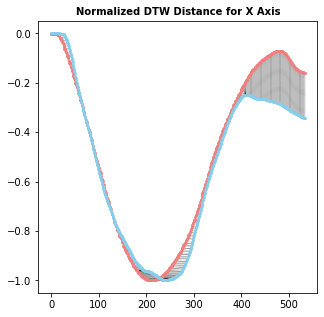

axis choice = 2
9.104375810817032


<Figure size 432x288 with 0 Axes>

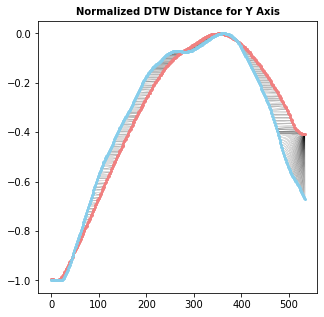

axis choice = 3
6.088311103452426


<Figure size 432x288 with 0 Axes>

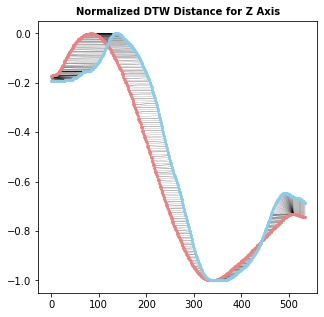

axis choice = 3
6.088311103452426
axis choice = 1
13.761843662910053


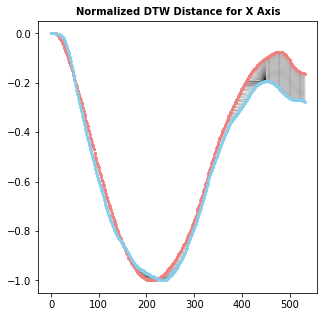

axis choice = 2
8.176343724078517


<Figure size 432x288 with 0 Axes>

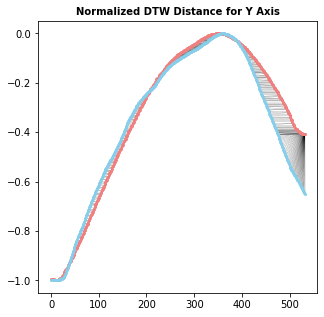

axis choice = 3
5.818828564574252


<Figure size 432x288 with 0 Axes>

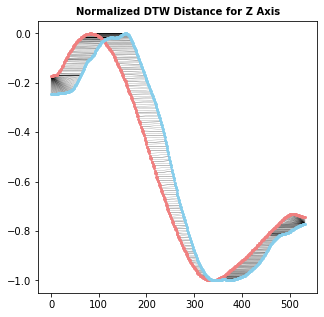

axis choice = 3
5.818828564574252
axis choice = 1
28.357729865709306


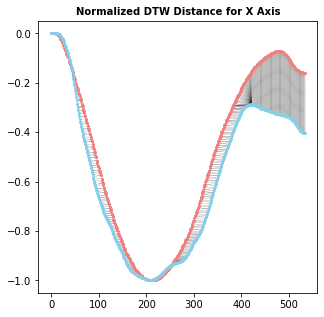

axis choice = 2
4.899855775793184


<Figure size 432x288 with 0 Axes>

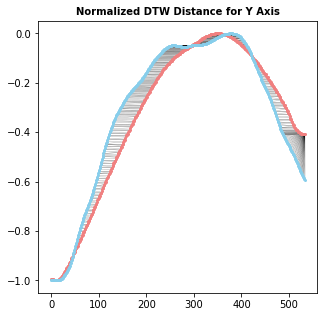

axis choice = 3
4.6824622709021355


<Figure size 432x288 with 0 Axes>

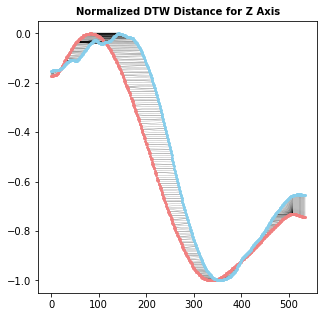

axis choice = 3
4.6824622709021355
axis choice = 1
4.677544486219364


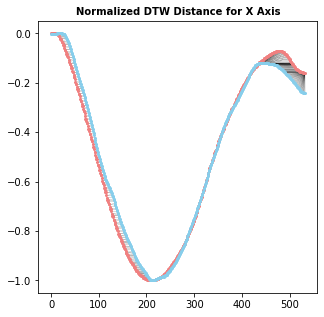

axis choice = 2
5.0784350471425785


<Figure size 432x288 with 0 Axes>

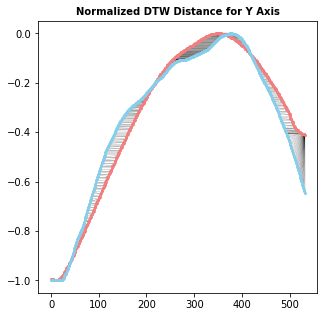

axis choice = 3
8.665298080529736


<Figure size 432x288 with 0 Axes>

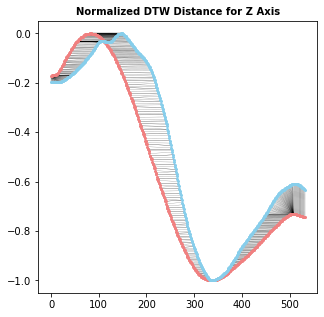

axis choice = 1
4.677544486219364
axis choice = 1
1.961436079273724


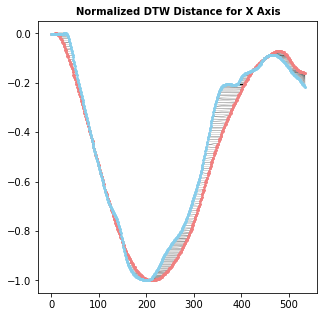

axis choice = 2
6.59862412067364


<Figure size 432x288 with 0 Axes>

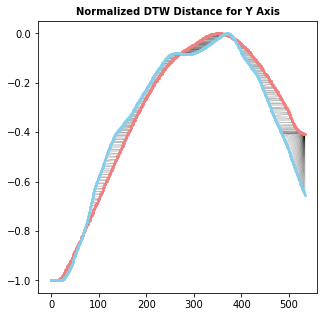

axis choice = 3
40.52147610707661


<Figure size 432x288 with 0 Axes>

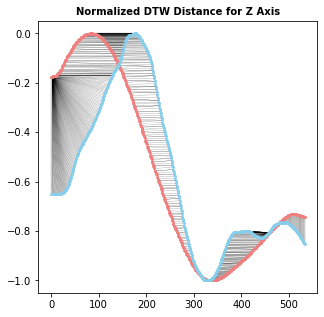

axis choice = 1
1.961436079273724


In [65]:
# Functions are all defined. Let's grab some data sets and get them ordered
for set_num in range(0,9):
#     print(set_num)
#     axis_choice = 2 #default axis for DTW = Y
    for run in range(10,0,-1):
#         print(set_num, run)
        end_eff_data, hand_data, joint_data = dtw_data_import(set_num, run)
        warp_path, axis_choice = find_norm(set_num, run, end_eff_data, hand_data)
        time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned = \
            full_align(warp_path, end_eff_data, hand_data)
        time_ja_aligned, joint_data_aligned = full_joint_align(time_URDF_aligned, joint_data)
        hand_rot_aligned = clean_rot_data(set_num, run, hand_rot_aligned)
        hand_rot_aligned = clean_rot_data(set_num, run, hand_rot_aligned)
        hand_rot_aligned = clean_rot_data(set_num, run, hand_rot_aligned)
        end_eff_rot_aligned = clean_rot_data(set_num, run, end_eff_rot_aligned) 
        end_eff_rot_aligned = clean_rot_data(set_num, run, end_eff_rot_aligned) 
        end_eff_rot_aligned = clean_rot_data(set_num, run, end_eff_rot_aligned) 
        plot_pos(set_num, run, warp_path, end_eff_pos_aligned, hand_pos_aligned)
        plot_rot(set_num, run, warp_path, end_eff_rot_aligned, hand_rot_aligned)
        
        np.savez('data_'+str(set_num)+'_'+str(run),time_URDF_aligned=time_URDF_aligned, time_hand_aligned=time_hand_aligned,\
                end_eff_pos_aligned=end_eff_pos_aligned, end_eff_rot_aligned=end_eff_rot_aligned, \
                hand_pos_aligned=hand_pos_aligned, hand_rot_aligned=hand_rot_aligned, \
                set_num=set_num, run=run, warp_path=warp_path, end_eff_data=end_eff_data, hand_data=hand_data,\
                time_ja_aligned=time_ja_aligned,joint_data_aligned=joint_data_aligned)


Text(0.5, 0.92, 'DTW Alignment of Hand Position and First Three URDF Joint Angles')

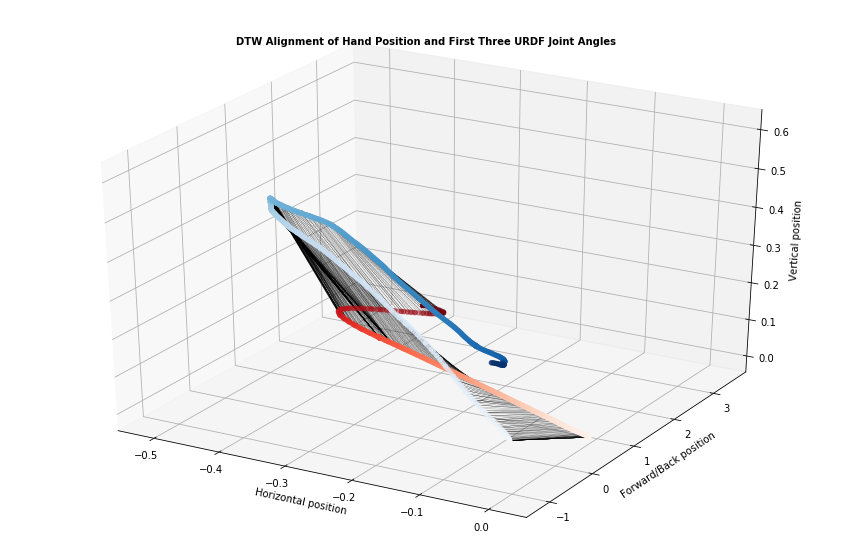

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_visible(True)
ax.axis('on')

ax = plt.axes(projection='3d')
joints = [3,4,5]

ax.scatter(joint_data_aligned[...,joints[0]], joint_data_aligned[...,joints[1]], joint_data_aligned[...,joints[2]], \
          c=time_ja_aligned/max(time_ja_aligned), cmap='Reds', label='Joint Angle Values')
ax.scatter(hand_pos_aligned[...,0]   , -hand_pos_aligned[...,2]   , hand_pos_aligned[...,1]   , \
          c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

for [map_x, map_y] in warp_path: 
    ax.plot3D([joint_data_aligned[map_x].T[joints[0]], hand_pos_aligned[map_y].T[0]], \
              [joint_data_aligned[map_x].T[joints[1]], -hand_pos_aligned[map_y].T[2]],\
              [joint_data_aligned[map_x].T[joints[2]], hand_pos_aligned[map_y].T[1]], \
              '--k', linewidth=0.2)
    
ax.set_xlabel('Horizontal position')
ax.set_ylabel('Forward/Back position')
ax.set_zlabel('Vertical position')

ax.set_title("DTW Alignment of Hand Position and First Three URDF Joint Angles", fontsize=10, fontweight="bold")


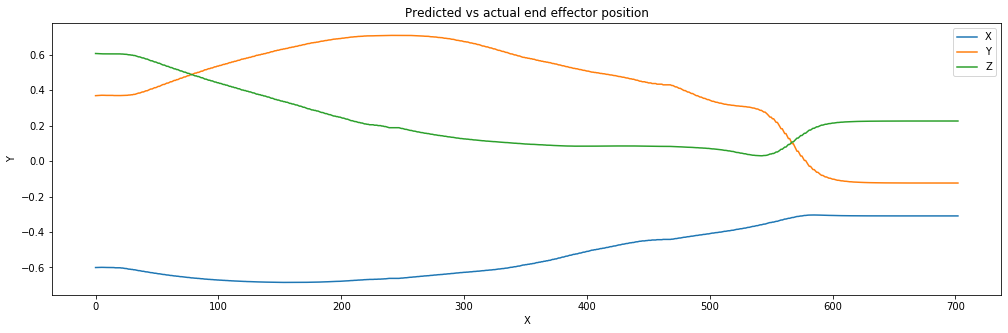

In [41]:
f = plt.figure(figsize=[17.0, 5.0])


ax = f.add_subplot(111)
labels = ('X','Y','Z')
errorlabels = ('One STD')
ax.plot(end_eff_rot_aligned)


    
ax.set_xlabel('X');
ax.set_ylabel('Y');
ax.set_title('Predicted vs actual end effector position');
ax.legend(('X','Y','Z'));
# plt.savefig('Error.png')
plt.show()
plt.close('all')

In [40]:
end_eff_rot_aligned = clean_rot_data(set_num, run, end_eff_rot_aligned)

In [32]:
hand_rot_aligned = clean_rot_data(set_num, run, hand_rot_aligned)

In [ ]:
len(time_match[0])

In [61]:
end_eff_data.shape

(634, 7)